<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [45]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2024-08-22 23:09:01--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2024-08-22 23:09:01--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2024-08-22 23:09:01 (14.5 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2024-08-22 23:09:01--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.002s (14.5 MB/s)


In [5]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)

        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [6]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2024-08-22 23:09:01--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2024-08-22 23:09:01--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2024-08-22 23:09:02--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [7]:
# Posibles bandas
os.listdir("./songs_dataset/")

['bob-marley.txt',
 'prince.txt',
 'jimi-hendrix.txt',
 'blink-182.txt',
 'notorious_big.txt',
 'nickelback.txt',
 'adele.txt',
 'nirvana.txt',
 'paul-simon.txt',
 'cake.txt',
 'kanye.txt',
 'michael-jackson.txt',
 'johnny-cash.txt',
 'dr-seuss.txt',
 'bjork.txt',
 'lil-wayne.txt',
 'bruno-mars.txt',
 'bruce-springsteen.txt',
 'dickinson.txt',
 'bieber.txt',
 'lady-gaga.txt',
 'Kanye_West.txt',
 'nicki-minaj.txt',
 'kanye-west.txt',
 'joni-mitchell.txt',
 'britney-spears.txt',
 'r-kelly.txt',
 'leonard-cohen.txt',
 'disney.txt',
 'notorious-big.txt',
 'alicia-keys.txt',
 'lorde.txt',
 'missy-elliott.txt',
 'al-green.txt',
 'patti-smith.txt',
 'amy-winehouse.txt',
 'rihanna.txt',
 'drake.txt',
 'Lil_Wayne.txt',
 'radiohead.txt',
 'ludacris.txt',
 'dj-khaled.txt',
 'dolly-parton.txt',
 'janisjoplin.txt',
 'beatles.txt',
 'eminem.txt',
 'lin-manuel-miranda.txt',
 'bob-dylan.txt',
 'nursery_rhymes.txt']

In [8]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-8-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [9]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [10]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [11]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Yesterday, all my troubles seemed so far away'

In [12]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [13]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [14]:
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

In [15]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [16]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
# seq_input + output
text_sequences

[['yesterday', 'all', 'my', 'troubles'],
 ['all', 'my', 'troubles', 'seemed'],
 ['my', 'troubles', 'seemed', 'so'],
 ['troubles', 'seemed', 'so', 'far']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [17]:
tok = Tokenizer()

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [18]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[6, 4, 2, 1], [4, 2, 1, 3], [2, 1, 3, 5], [1, 3, 5, 7]]

In [19]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

4


In [20]:
# Cantidad de palabras distintas
print(len(tok.word_counts))

7


In [21]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'troubles': 1, 'my': 2, 'seemed': 3, 'all': 4, 'so': 5, 'yesterday': 6, 'far': 7}


In [22]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'troubles': 4, 'yesterday': 1, 'my': 3, 'all': 2, 'seemed': 3, 'so': 2, 'far': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [23]:
# Vistazo a las primeras filas
df.loc[:15,0]

,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."
5,"I said something wrong, now I long for yesterd..."
6,Now I need a place to hide away
7,"Oh, I believe in yesterday Why she had to go I..."
8,"I said something wrong, now I long for yesterd..."
9,Now I need a place to hide away


In [24]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Yesterday, all my troubles seemed so far away Now it looks as though they\'re here to stay Oh, I believe in yesterday Suddenly, I\'m not half the man I used to be There\'s a shadow hanging over me. Oh, yesterday came suddenly Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me Speaking words of wisdom, let it be And in my hour of darkness she is standing right in front of me Speaking words of wisdom, let it be Let it be, let it be, let it be, let it be Whisper words of wisdom, let it be And when the broken hearted people living in the world agree There

In [25]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['yesterday',
 'all',
 'my',
 'troubles',
 'seemed',
 'so',
 'far',
 'away',
 'now',
 'it',
 'looks',
 'as',
 'though',
 "they're",
 'here',
 'to',
 'stay',
 'oh',
 'i',
 'believe']

In [26]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 14387


In [27]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [28]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['yesterday', 'all', 'my', 'troubles'],
 ['all', 'my', 'troubles', 'seemed'],
 ['my', 'troubles', 'seemed', 'so'],
 ['troubles', 'seemed', 'so', 'far'],
 ['seemed', 'so', 'far', 'away'],
 ['so', 'far', 'away', 'now'],
 ['far', 'away', 'now', 'it'],
 ['away', 'now', 'it', 'looks'],
 ['now', 'it', 'looks', 'as'],
 ['it', 'looks', 'as', 'though'],
 ['looks', 'as', 'though', "they're"],
 ['as', 'though', "they're", 'here'],
 ['though', "they're", 'here', 'to'],
 ["they're", 'here', 'to', 'stay'],
 ['here', 'to', 'stay', 'oh'],
 ['to', 'stay', 'oh', 'i'],
 ['stay', 'oh', 'i', 'believe'],
 ['oh', 'i', 'believe', 'in'],
 ['i', 'believe', 'in', 'yesterday'],
 ['believe', 'in', 'yesterday', 'suddenly']]

In [29]:
# Proceso de tokenizacion
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[216, 10, 12, 907],
 [10, 12, 907, 908],
 [12, 907, 908, 42],
 [907, 908, 42, 909],
 [908, 42, 909, 121],
 [42, 909, 121, 22],
 [909, 121, 22, 13],
 [121, 22, 13, 638],
 [22, 13, 638, 91],
 [13, 638, 91, 217],
 [638, 91, 217, 349],
 [91, 217, 349, 79],
 [217, 349, 79, 4],
 [349, 79, 4, 314],
 [79, 4, 314, 23],
 [4, 314, 23, 2],
 [314, 23, 2, 160],
 [23, 2, 160, 9],
 [2, 160, 9, 216],
 [160, 9, 216, 520]]

In [30]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 14383


### 3 - Input y target

In [31]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [32]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [33]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [34]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(14383, 3)
(14383,)


In [35]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'together',
 47: 'no',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [36]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [37]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [38]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [39]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 1628


In [40]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 11507
Tamaño del conjunto de validacion: 2876


### 4 - Entrenar el modelo

In [41]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1628]                 --
├─Embedding: 1-1                         [1, 3, 5]                 8,145
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1628]                 53,724
├─Softmax: 1-6                           [1, 1628]                 --
Total params: 115,405
Trainable params: 115,405
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.46
Estimated Total Size (MB): 0.48

In [ ]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 7.315 - Train accuracy 0.082 - Valid Loss 7.350 - Valid accuracy 0.046
Epoch: 2/200 - Train loss 7.314 - Train accuracy 0.082 - Valid Loss 7.351 - Valid accuracy 0.046
Epoch: 3/200 - Train loss 7.314 - Train accuracy 0.082 - Valid Loss 7.350 - Valid accuracy 0.046
Epoch: 4/200 - Train loss 7.313 - Train accuracy 0.083 - Valid Loss 7.352 - Valid accuracy 0.045
Epoch: 5/200 - Train loss 7.313 - Train accuracy 0.083 - Valid Loss 7.349 - Valid accuracy 0.048
Epoch: 6/200 - Train loss 7.313 - Train accuracy 0.084 - Valid Loss 7.350 - Valid accuracy 0.047
Epoch: 7/200 - Train loss 7.313 - Train accuracy 0.083 - Valid Loss 7.353 - Valid accuracy 0.043
Epoch: 8/200 - Train loss 7.312 - Train accuracy 0.084 - Valid Loss 7.351 - Valid accuracy 0.046
Epoch: 9/200 - Train loss 7.311 - Train accuracy 0.085 - Valid Loss 7.351 - Valid accuracy 0.045
Epoch: 10/200 - Train loss 7.311 - Train accuracy 0.085 - Valid Loss 7.350 - Valid accuracy 0.046
Epoch: 11/200 - Train loss 7.

In [43]:
import torch
import torch.nn as nn

#Aumento del Embedding Dim: Incrementamos el tamaño del embedding a 128 para capturar más información semántica.
#Capas Convolucionales: Se agregaron dos capas Conv1D con MaxPooling para extraer características locales antes de alimentar los datos a la LSTM.
#Bidireccional LSTM: Convertimos la LSTM en bidireccional para capturar dependencias en ambas direcciones de la secuencia.
#Capas LSTM: Incrementamos el número de capas LSTM de 2 a 3, y el tamaño del hidden state de 64 a 256.
#Capas Fully Connected: Se añadió una capa adicional con 64 unidades y se incrementó la primera capa a 128 unidades.
#Dropout: Se añadió Dropout después de la primera capa totalmente conectada para reducir el riesgo de overfitting.



class Model2(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # Incrementamos el tamaño del embedding y las dimensiones de la LSTM
        self.embedding_dim = 128  # Aumentamos el tamaño de los embeddings
        self.lstm_size = 256  # Aumentamos el tamaño de los hidden states
        self.num_layers = 3  # Aumentamos el número de capas LSTM

        # Embedding Layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)

        # Añadimos una capa convolucional antes de la LSTM
        self.conv1 = nn.Conv1d(in_channels=self.embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # LSTM Layer
        self.lstm1 = nn.LSTM(input_size=256, hidden_size=self.lstm_size, batch_first=True,
                             num_layers=self.num_layers, dropout=0.3, bidirectional=True)  # Bidirectional LSTM

        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=self.lstm_size * 2, out_features=128)  # Doble tamaño por la LSTM bidireccional
        self.fc2 = nn.Linear(in_features=128, out_features=64)  # Capa adicional
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)

        # Conv1D layers
        out = self.conv1(out.transpose(1, 2))  # Conv1D espera (batch_size, embedding_dim, sequence_length)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.pool(out)

        out = out.transpose(1, 2)  # Volvemos a (batch_size, sequence_length, conv_output_dim)

        # LSTM layers
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)

        # Fully Connected layers
        out = self.relu(self.fc1(lstm_output[:, -1, :]))  # Consideramos la última salida
        out = self.dropout(out)  # Dropout para evitar overfitting
        out = self.relu(self.fc2(out))  # Capa adicional
        out = self.fc3(out)
        out = self.softmax(out)

        return out

    def init_hidden(self, batch_size):
        # Inicializamos los hidden states para una LSTM bidireccional
        return (torch.zeros(self.num_layers * 2, batch_size, self.lstm_size),
                torch.zeros(self.num_layers * 2, batch_size, self.lstm_size))

model2 = Model2(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador y la función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
model2_criterion = torch.nn.CrossEntropyLoss()

# Resumen del modelo
summary(model2, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))


Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 1628]                 --
├─Embedding: 1-1                         [1, 3, 128]               208,512
├─Conv1d: 1-2                            [1, 128, 3]               49,280
├─ReLU: 1-3                              [1, 128, 3]               --
├─Conv1d: 1-4                            [1, 256, 3]               98,560
├─ReLU: 1-5                              [1, 256, 3]               --
├─MaxPool1d: 1-6                         [1, 256, 1]               --
├─LSTM: 1-7                              [1, 1, 512]               4,206,592
├─Linear: 1-8                            [1, 128]                  65,664
├─ReLU: 1-9                              [1, 128]                  --
├─Dropout: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 64]                   8,256
├─ReLU: 1-12                             [1, 64]          

In [44]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 7.379 - Train accuracy 0.019 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 2/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 3/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 4/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 5/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 6/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 7/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 8/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 9/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 10/100 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 11/100 - Train loss 7.

In [46]:
import torch
import torch.nn as nn

class Model3(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # Aumentamos el tamaño de embedding y las capas LSTM
        self.embedding_dim = 128
        self.lstm_size = 256
        self.num_layers = 4  # Aumentamos el número de capas LSTM

        # Embedding Layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=self.embedding_dim, padding_idx=0)

        # LSTM Layer
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                             num_layers=self.num_layers, dropout=0.3)

        # Fully Connected Layers con más neuronas
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=output_dim)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, prev_state=None):
        if prev_state is None:
            batch_size = x.shape[0]
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)

        # Fully Connected layers
        out = self.relu(self.fc1(lstm_output[:, -1, :]))  # Último hidden state
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        out = self.softmax(out)

        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model3 = Model3(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador y la función de error
model3_optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
model3_criterion = torch.nn.CrossEntropyLoss()

# Resumen del modelo
summary(model3, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))


Layer (type:depth-idx)                   Output Shape              Param #
Model3                                   [1, 1628]                 --
├─Embedding: 1-1                         [1, 3, 128]               208,512
├─LSTM: 1-2                              [1, 3, 256]               1,974,272
├─Linear: 1-3                            [1, 128]                  32,896
├─ReLU: 1-4                              [1, 128]                  --
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 64]                   8,256
├─ReLU: 1-7                              [1, 64]                   --
├─Dropout: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 32]                   2,080
├─ReLU: 1-10                             [1, 32]                   --
├─Linear: 1-11                           [1, 1628]                 53,724
├─Softmax: 1-12                          [1, 1628]         

In [47]:
history3 = train(model3,
                train_loader,
                valid_loader,
                model3_optimizer,
                model3_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 7.354 - Train accuracy 0.043 - Valid Loss 7.356 - Valid accuracy 0.041
Epoch: 2/200 - Train loss 7.347 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 3/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 4/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 5/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 6/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 7/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 8/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 9/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 10/200 - Train loss 7.346 - Train accuracy 0.050 - Valid Loss 7.356 - Valid accuracy 0.040
Epoch: 11/200 - Train loss 7.

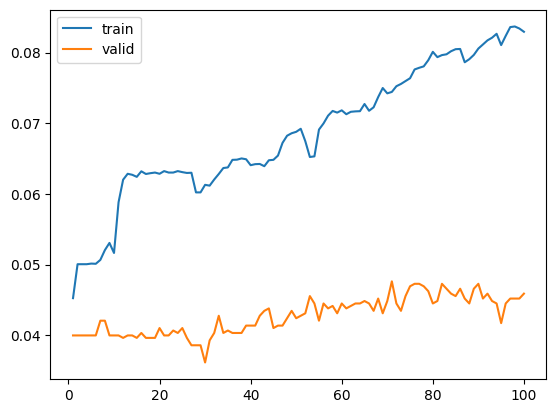

In [48]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

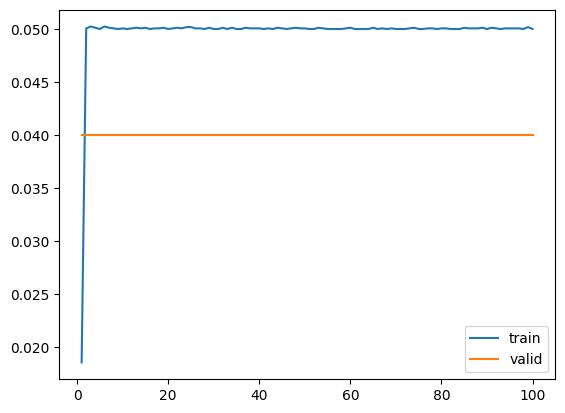

In [49]:
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

__Es importante__ destacar que en este ejemplo estamos entrenando nuestro propios Embeddings y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.

**CONCLUSION : **En ninguna de las alternativas realizadas al entrenamiento se encuentran buenos resultados , dentro de las alternativas , se realizo incremento de epochs , agrandado de la red neuronal agradando mas complejidad e incluso se agrego bidireccion en la lstm , en ningun caso se encontro mejor desempeño. Incluso algunos casos no tuvieron convergencia , a pesar de tener un learning rate bajo.


### 5 - Predicción de próxima palabra

In [50]:
# pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [51]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 10.5 MB/s eta 0:00:00


In [52]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

TypeError: BlockContext.__init__() got an unexpected keyword argument 'layout'

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey jude don\'t'

generate_seq(model1, tok, input_text, max_length=3, n_words=2)

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.